# Predicting Risk of Heart Disease Using Clinical Indicators

# Introduction
Heart disease is a leading cause of death worldwide, and early prediction can significantly improve patient outcomes. Machine learning techniques can be used to analyze clinical and demographic data to predict the presence of heart disease. This project will utilize a modified version of the UCI Heart Disease dataset to develop a predictive model for heart disease. 
### Research Question:
Can we accurately predict the presence of heart disease (`num`) from processed Cleveland dataset (using `age`, `trestbps`, `chol`, and `thalach` as predictor variable)?
### Dataset:
The dataset used for this analysis is a modified version of the UCI Heart Disease dataset (processed Cleveland data). It contains 14 columns but I will only use 5 columns mentioned below.

1. `age`: age (years)

2. `trestbps`: resting blood pressure (in $mm$ $Hg$ on admission to the hospital)

3. `chol`: serum cholesterol in $mg/dl$

4. `thalach`: maximum heart rate achieved

5. `num`: diagnosis of heart disease (the predicted attribute)

            -- Value 0: No heart disease diagnosed
    
            -- Value 1 - 4: Heart disease diagnosed (1 being least severe and 4 being most severe heart disease)

# Methods and Results:

In [112]:
#run this cell ; it loads the libraries for us to use.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

## Reading Data into Jupyter Lab

In [113]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/45/heart+disease.zip", temp)
con_cleveland <- unzip(temp, "processed.cleveland.data")
cleveland_data <- read.table(con_cleveland, sep = ",", col.names = c("age", "sex", "cp", "trestbps", "chol", 
                                         "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

head(cleveland_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


## Cleaning Data
In this project I am only focusing on 4 variables `age`, `trestbps`, `chol`, and `thalach` to predict `num` (Diagnosis of Heart Disease). Therefore I will select the above mentioned 4 columns using `select()` and converting our `num` column from integer to categorical using `mutate()`.

In [114]:
cleveland_data <- cleveland_data |> 
                   select(age, trestbps, chol, thalach, num) |> 
                    mutate(num = as_factor(num))
head(cleveland_data)

,age,trestbps,chol,thalach,num
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,145,233,150,0
2,67,160,286,108,2
3,67,120,229,129,1
4,37,130,250,187,0
5,41,130,204,172,0
6,56,120,236,178,0


## Splitting Data into Training set and Testing set

In [115]:
set.seed(2000)

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
37,130,250,187,0
41,130,204,172,0
⋮,⋮,⋮,⋮,⋮
55,128,205,130,3
59,164,176,90,3
57,130,131,115,3


## Summary Table
This table shows the number of observation per different value of `num`with their respective mean values for `age`, `chol`, `trestbps`, and `thalach`

In [116]:
summary_cleveland_training <- cleveland_training |> group_by(num) |> summarize(count = n(),
                                                                               mean_age = mean(age, na.rm = TRUE),
                                                                               mean_trestbps = mean(trestbps, na.rm = TRUE),
                                                                               mean_chol = mean(chol, na.rm = TRUE),
                                                                               mean_thalach = mean(thalach, na.rm = TRUE))

summary_cleveland_training

num,count,mean_age,mean_trestbps,mean_chol,mean_thalach
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,122,52.96721,128.8115,244.4754,158.4672
1,40,54.87500,133.6500,250.5250,147.7000
2,26,57.69231,132.6923,261.3846,138.2308
3,26,55.73077,136.3462,248.8846,134.1154
4,12,61.50000,140.3333,255.2500,137.1667


## Visualization of Data
The plot below shows distribution different predictors `age`, `trestbps`, `chol`, and `thalach` by Heart disease status to better understand the relation ship of the predictors with `num`.

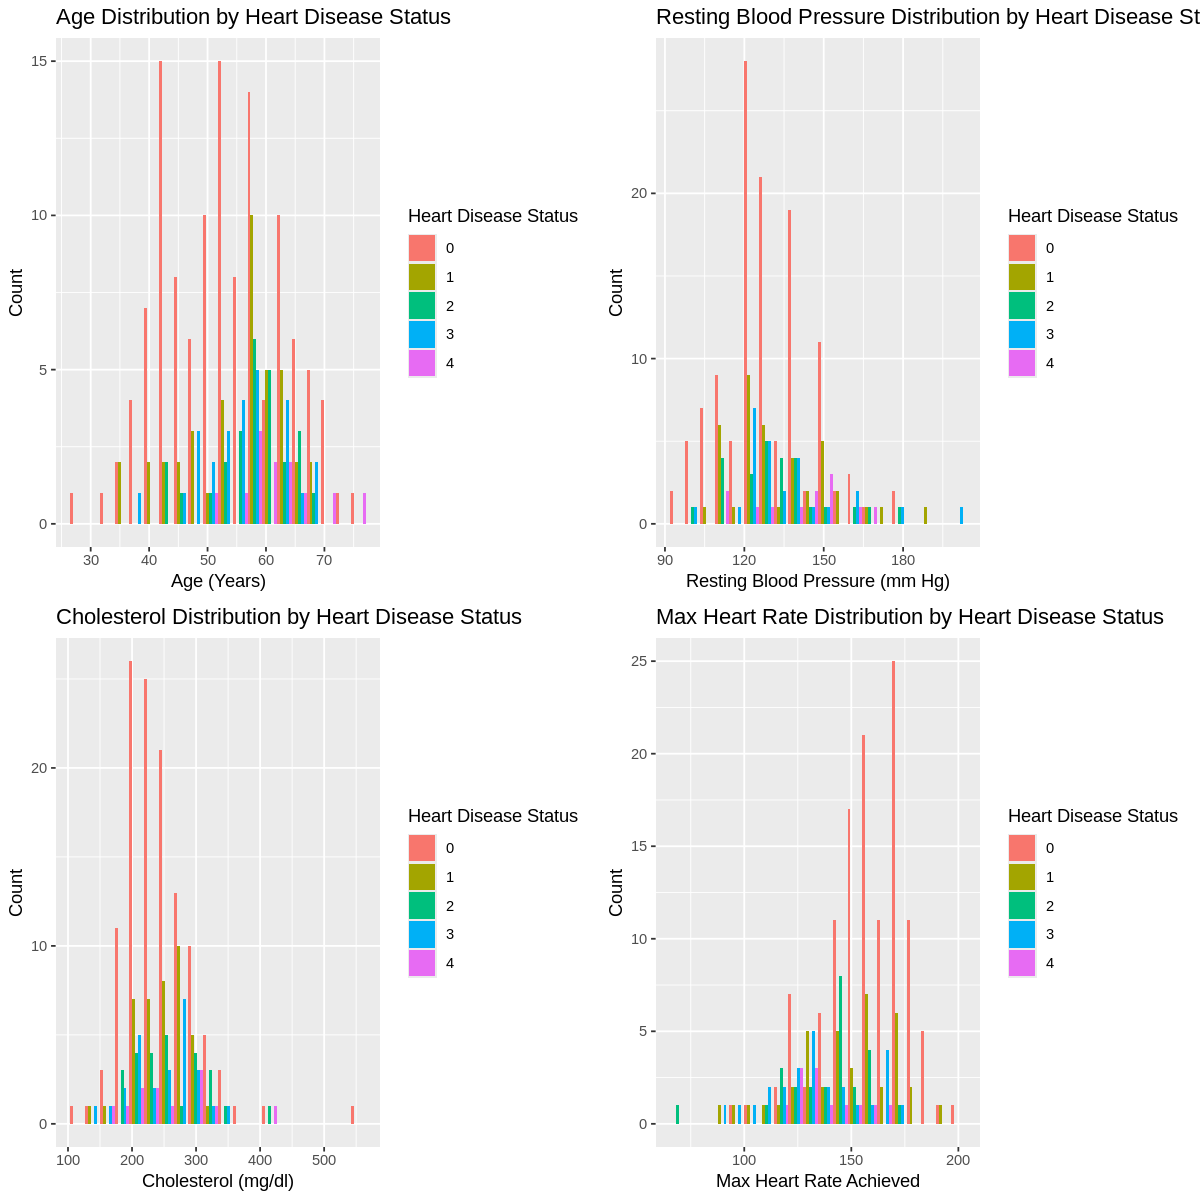

In [117]:
options(repr.plot.width = 10, repr.plot.height = 10) 
age_plot <- ggplot(cleveland_training, aes(x = age, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Age Distribution by Heart Disease Status", 
                  x = "Age (Years)", 
                  y = "Count",
                  fill = "Heart Disease Status")

trestbps_plot <- ggplot(cleveland_training, aes(x = trestbps, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Resting Blood Pressure Distribution by Heart Disease Status", 
                  x = "Resting Blood Pressure (mm Hg)",
                  y = "Count",  
                  fill = "Heart Disease Status")

chol_plot <- ggplot(cleveland_training, aes(x = chol, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Cholesterol Distribution by Heart Disease Status", 
                  x = "Cholesterol (mg/dl)", 
                  y = "Count",
                  fill = "Heart Disease Status")

thalach_plot <- ggplot(cleveland_training, aes(x = thalach, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Max Heart Rate Distribution by Heart Disease Status", 
                  x = "Max Heart Rate Achieved", 
                  y = "Count",
                  fill = "Heart Disease Status")
plot_grid(age_plot, trestbps_plot, chol_plot, thalach_plot, ncol = 2)

## Data Analysis:

I will use logistic regression for classification (KNN - Kth nearest algorithm). The model will be trained using the training dataset and validated with a testing set. Key variables considered will include `age`, `trestbps`, `chol`, and `thalach`.
First I will find the best value for K (nearest neighbor) in order to get the best results in terms of accuracy. After that, I will use the founded K value on classification model to check the accuracy and precision of the model on testing data set.

### Making Recipe
selecting target variable `num` and setting predictors to `age`, `trestbps`, `chol`, and `thalach`

In [118]:
set.seed(2000)

cleveland_recipe <- recipe(num ~ ., data = cleveland_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### Performing Cross Validation

In [119]:
set.seed(2000)
cleveland_vfold <- vfold_cv(cleveland_training, v = 5, strata = num)

### Finding Best K
- We can observe the plot for different k value vs accuracy of model to find the best value of k possible in this case it is found to be $12$.

[1] 12

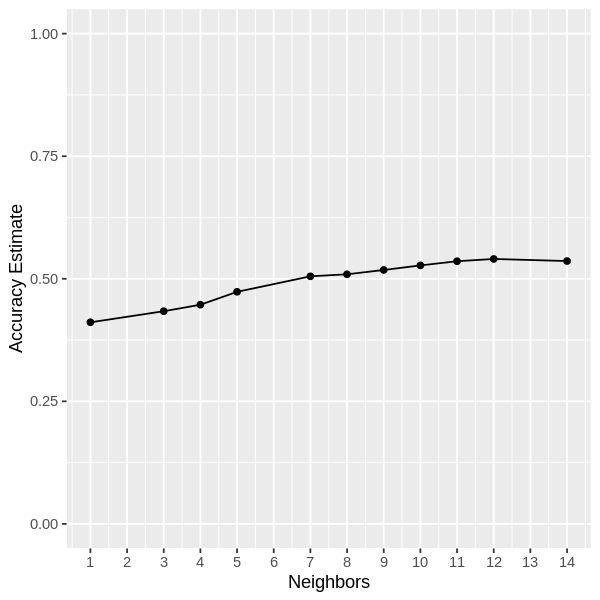

In [120]:
set.seed(2000)
options(repr.plot.width = 5, repr.plot.height = 5)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_results <- workflow() |>
       add_recipe(cleveland_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = cleveland_vfold, grid = 15) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

best_k <- accuracies |> arrange(desc(mean)) |> slice(1) |> pull(neighbors)

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0, 1.0)) # adjusting the y-axis
accuracy_versus_k
best_k

### Visualisation Of Data:
- We can observe the accuracy of the model on `cleveland_metrics` tibble which about 49.3%
- Confusion matrix is showns as tibble `cleveland_conf_mat`, which gives indepth insight on how the model performed.

In [121]:
set.seed(2000)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_engine("kknn") |>
            set_mode("classification")

cleveland_fit <- workflow() |>
             add_recipe(cleveland_recipe) |>
             add_model(knn_spec) |>
            fit(data = cleveland_training)

cleveland_predictions <- predict(cleveland_fit, cleveland_testing) |> bind_cols(cleveland_testing)
cleveland_metrics <- cleveland_predictions |> metrics(truth = num, estimate = .pred_class)
cleveland_conf_mat <- cleveland_predictions |> conf_mat(truth = num, estimate = .pred_class)

cleveland_metrics

cleveland_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.49350649
kap,multiclass,0.02563271


          Truth
Prediction  0  1  2  3  4
         0 37 12  7  8  1
         1  1  1  1  1  0
         2  1  0  0  0  0
         3  2  1  2  0  0
         4  1  1  0  0  0

# Discussion

## Summary of Findings

KNN classification model showed substandard accuracy of 49.35% in predicting heart disease of different codition based on how severe it is (i.e num value of 1-4). This shows that there are more predictors other than `age`, `chol`, `trestbps`, and `thalach` which are affecting the results.

## Expected vs. Actual Findings

These findings align with expectations, as clinical indicators like age, cholesterol, and heart rate are known predictors of heart disease . Logistic regression provided clear insights into how each predictor influenced the likelihood of heart disease. Model did not perform that well as it was expected it idicates that the 4 used predictors aren't the main driving force for heart diseases.

## Impact of Findings

These models can be used as tools in clinical settings to aid early detection and treatment of heart disease, emphasizing the importance of regular clinical measurements. 

## Future Questions

1. Model Enhancements: Could other machine learning models provide better accuracy or additional insights?

2. Additional Variables: How would including more clinical or demographic factors improve prediction accuracy?

3. Real-World Applications: How can these models be integrated into healthcare systems to assist in clinical decision-making?

# References

Detrano, Robert C. et al. “International application of a new probability algorithm for the diagnosis of coronary artery disease.” The American journal of cardiology 64 5 (1989): 304-10 .

Nashif, S. et al. “Heart Disease Detection by Using Machine Learning Algorithms and a Real-Time Cardiovascular Health Monitoring System.” World Journal of Engineering and Technology 06 (2018): 854-873.

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.